# Classique avec 6 data aug ( pivoter de 5, 10 et 15 degrés à droite et à gauche) : 85.5% d'accuracy sur test set

# On importe nos données comme d'habitude 

In [1]:
%%time

num_aug=7


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

from glob import glob
import os


imPath = "Database/All_pictures/"
ls_path = glob(os.path.join(imPath, '*' ))

images_base_vide=[]
label_nom_vide=[]

for file in ls_path: 
    im = np.array(Image.open(file))[:,:,3]   
    images_base_vide+=[im]
    label_nom_vide+=[file.split('\\')[1].split('_')[0]]   
images_base_raw=np.array(images_base_vide)
label_nom_raw=np.array(label_nom_vide)

def print_exemple_image(num_image,X=images_base_raw,y=label_nom_vide) :
    plt.imshow(X[num_image],cmap='Greys')
    plt.suptitle("Image n°"+str(num_image)+" : "+str(y[num_image]), fontsize=20)
    
from sklearn.model_selection import train_test_split

ramdom_seed_fixée=5

def get_split_classique() :
    return train_test_split(images_base_raw, label_nom_raw, test_size=0.20, random_state=ramdom_seed_fixée)

X_train_classique , X_test_classique , Y_train_classique , Y_test_classique = get_split_classique()

label_to_OneHot = {'Deezer':[1,0,0,0],'Messenger':[0,1,0,0],'Facebook':[0,0,1,0],'Tinder':[0,0,0,1]}
label_to_num = {'Deezer':0 ,'Messenger':1 ,'Facebook':2,'Tinder':3} 
num_to_label={0:'Deezer',1:'Messenger' ,2:'Facebook',3:'Tinder'}

def transformation_dictionnaire_image(X,Y,data_aug=1,num_pixel_cote=64) : 
    taille = X.shape[0]
    data_base={'image':[], 'data': [], 'label_num' : [],'label_OneHot' : [],'nom_label' :[]}
    for i in range(taille) : 
        im = cv2.resize(X[i], (num_pixel_cote,num_pixel_cote))
        name=Y[i]
        
        for k in range(data_aug):
            deg_rot=(k%2)*(((k+1)//2))*5+(1-k%2)*(((k+1)//2)*(-5))
            num_rows, num_cols = im.shape[:2]
            rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), deg_rot, 1)
            im_rotation = cv2.warpAffine(im, rotation_matrix, (num_cols, num_rows))
        
            
            data_base['image']+=[im_rotation]
            data_base['data']+=[np.ndarray.flatten(im_rotation)]
            data_base['label_num']+=[label_to_num[name]]
            data_base['label_OneHot']+=[label_to_OneHot[name]]
            data_base['nom_label']+=[name]
            
            
    data_base['image']=np.array( data_base['image'])
    data_base['data']=np.array(data_base['data'])
    data_base['label_num']=np.array(data_base['label_num'])
    data_base['label_OneHot']=np.array(data_base['label_OneHot'])
    data_base['nom_label']=np.array(data_base['nom_label'])
    
    return data_base
        
Train_Classique = transformation_dictionnaire_image(X_train_classique,Y_train_classique,data_aug=num_aug)
Test_Classique = transformation_dictionnaire_image(X_test_classique,Y_test_classique)

catégories= ['Deezer','Facebook','Messenger','Tinder']

X_train_progressif , X_test_progressif , Y_train_progressif , Y_test_progressif = [],[],[],[]

for cat in catégories : 
    imPath = "Database/"+cat+"/"
    ls_path = glob(os.path.join(imPath, '*' ))

    taille_train=len(ls_path)-len(ls_path)//5
    #Train
    for file in ls_path[:taille_train]: 
        im = np.array(Image.open(file))[:,:,3]   
        X_train_progressif+=[im]
        Y_train_progressif+=[file.split('\\')[1].split('_')[0]]

    #Test
    for file in ls_path[taille_train:]: 
        im = np.array(Image.open(file))[:,:,3]   
        X_test_progressif+=[im]
        Y_test_progressif+=[file.split('\\')[1].split('_')[0]]
    

X_train_progressif=np.array(X_train_progressif)
Y_train_progressif=np.array(Y_train_progressif)
X_test_progressif=np.array(X_test_progressif)
Y_test_progressif=np.array(Y_test_progressif)


Train_Progressif = transformation_dictionnaire_image(X_train_progressif,Y_train_progressif,data_aug=num_aug)
Test_Progressif = transformation_dictionnaire_image(X_test_progressif,Y_test_progressif)

Wall time: 59.7 s


In [2]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import random

In [3]:
# Premier convolutional Layer.
filter_size1 = 5          # Filtre de 5 x 5 pixels.
num_filters1 = 16         # Il y a ici 16 filtres.

# Deuxième convolutional Layer
filter_size2 = 5          # Filtre de 5 x 5 pixels.
num_filters2 = 36         # Il y a ici 36 filtres .

# Couche fully connected 
fc_size = 128             # Nombre de neuronnes dans la dernière couche 

In [4]:
Train_dic=Train_Classique
Test_dic=Test_Classique

In [5]:
print("Taille du:")
print("- Training set:\t\t{}".format(Train_dic['image'].shape[0]))
print("- Test set:\t\t{}".format(Test_dic['image'].shape[0]))

Taille du:
- Training set:		8456
- Test set:		303


In [6]:
# Nombre pixel coté
img_size = Train_dic['image'].shape[1]

# Nombre de pixel au total
img_size_flat = Train_dic['data'].shape[1]

# Nombre de pixel longeur et largeur 
img_shape = Train_dic['image'].shape[1:]

# Nombre de classes (si on ajoute de nouveaux logos)
num_classes = 4 

# Noir et blanc ? 1 si oui 
num_channels = 1

In [7]:
def plot_images(images, cls_vrai, cls_pred=None):
    assert len(images) == len(cls_vrai) == 9
    
    fig, axes = plt.subplots(3, 3,  figsize=(10,5))
    fig.subplots_adjust(hspace=0.3, wspace=0.1)

    for i, ax in enumerate(axes.flat):

        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "Vrai: {0}".format(cls_vrai[i])
        else:
            xlabel = "Vrai: {0}, Pred: {1}".format(cls_vrai[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        

    plt.show()

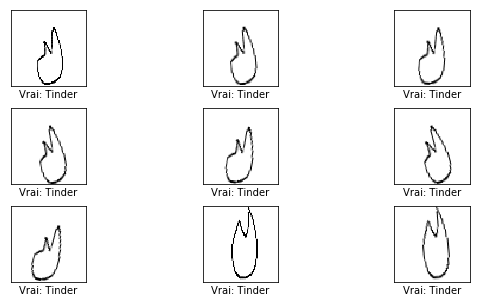

In [8]:
images = Train_dic['image'][0:9]
cls_vrai = [num_to_label[i] for i in Train_dic['label_num'][0:9]]


plot_images(images=images, cls_vrai=cls_vrai)

In [9]:
def crea_poids(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def nouveau_biais(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [10]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    weights = crea_poids(shape=shape)

    biases = nouveau_biais(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    layer += biases

    if use_pooling:

        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)

    return layer, weights

In [11]:
def flatten_layer(layer):

    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [12]:
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,    
                 use_relu=True): 

  
    weights = crea_poids(shape=[num_inputs, num_outputs])
    biases = nouveau_biais(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [13]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [14]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [15]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [16]:
y_true_cls = tf.argmax(y_true, axis=1)

In [17]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [18]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 16) dtype=float32>

In [19]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [20]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 16, 16, 36) dtype=float32>

In [21]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [22]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 9216) dtype=float32>

In [23]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [24]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [25]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [26]:
y_pred = tf.nn.softmax(layer_fc2)

In [27]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [28]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [29]:
cost = tf.reduce_mean(cross_entropy)

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [31]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [32]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [33]:
session = tf.Session()

In [34]:
session.run(tf.global_variables_initializer())

In [35]:
train_batch_size = 64

In [36]:
def get_random_batch(X,y,batch_size) :
    index=random.sample(range(1,y.shape[0]), batch_size)
    return X[index], y[index]

In [37]:
total_iterations = 0
batch_size=100

def optimize(num_iterations):
    
    global total_iterations
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        x_batch, y_true_batch = get_random_batch(Train_dic['data'],Train_dic['label_OneHot'],batch_size)


        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:

            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time

    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [38]:
def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    incorrect = (correct == False)
    images = Test_dic['data'][incorrect]
    cls_pred = cls_pred[incorrect]
    cls_vrai = Test_dic['label_num'][incorrect]
    plot_images(images=images[0:9],
                cls_vrai=[num_to_label[i] for i in cls_vrai[0:9]],
                cls_pred=[num_to_label[i] for i in cls_pred[0:9]])

In [39]:
def print_confusion_matrix():
    cls_vrai = Test_dic['label_num']
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_vrai, y_pred=cls_pred)

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.yticks(tick_marks, [num_to_label[i] for i in range(num_classes)])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [40]:
feed_dict_test = {x: Test_dic['data'],
                  y_true: Test_dic['label_OneHot'],
                  y_true_cls: Test_dic['label_num']}

In [41]:
def print_accuracy():

    acc = session.run(accuracy, feed_dict=feed_dict_test)

    print("Accuracy on test-set: {0:.1%}".format(acc))

In [42]:
print_accuracy()

Accuracy on test-set: 24.1%


In [43]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:  24.0%
Time usage: 0:00:03


In [44]:
print_accuracy()

Accuracy on test-set: 21.5%


In [45]:
for i in range(10): 
    optimize(num_iterations=100) 
    print_accuracy()

Optimization Iteration:    101, Training Accuracy:  76.0%
Time usage: 0:01:59
Accuracy on test-set: 58.1%
Optimization Iteration:    201, Training Accuracy:  81.0%
Time usage: 0:02:00
Accuracy on test-set: 68.6%
Optimization Iteration:    301, Training Accuracy:  86.0%
Time usage: 0:01:58
Accuracy on test-set: 72.3%
Optimization Iteration:    401, Training Accuracy:  91.0%
Time usage: 0:01:55
Accuracy on test-set: 77.6%
Optimization Iteration:    501, Training Accuracy:  94.0%
Time usage: 0:02:45
Accuracy on test-set: 78.2%
Optimization Iteration:    601, Training Accuracy:  94.0%
Time usage: 0:02:11
Accuracy on test-set: 77.9%
Optimization Iteration:    701, Training Accuracy:  94.0%
Time usage: 0:02:12
Accuracy on test-set: 78.9%
Optimization Iteration:    801, Training Accuracy: 100.0%
Time usage: 0:01:57
Accuracy on test-set: 82.2%
Optimization Iteration:    901, Training Accuracy: 100.0%
Time usage: 0:01:54
Accuracy on test-set: 82.5%
Optimization Iteration:   1001, Training Accur

In [46]:
for i in range(10): 
    optimize(num_iterations=100) 
    print_accuracy()

Optimization Iteration:   1101, Training Accuracy: 100.0%
Time usage: 0:01:52
Accuracy on test-set: 81.5%
Optimization Iteration:   1201, Training Accuracy: 100.0%
Time usage: 0:01:51
Accuracy on test-set: 81.2%
Optimization Iteration:   1301, Training Accuracy: 100.0%
Time usage: 0:01:51
Accuracy on test-set: 82.2%
Optimization Iteration:   1401, Training Accuracy: 100.0%
Time usage: 0:01:50
Accuracy on test-set: 82.2%
Optimization Iteration:   1501, Training Accuracy:  99.0%
Time usage: 0:01:51
Accuracy on test-set: 83.2%
Optimization Iteration:   1601, Training Accuracy: 100.0%
Time usage: 0:01:52
Accuracy on test-set: 81.2%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Time usage: 0:01:49
Accuracy on test-set: 81.2%
Optimization Iteration:   1801, Training Accuracy:  97.0%
Time usage: 0:01:49
Accuracy on test-set: 82.8%
Optimization Iteration:   1901, Training Accuracy: 100.0%
Time usage: 0:01:49
Accuracy on test-set: 82.8%
Optimization Iteration:   2001, Training Accur

[[55  3  2  3]
 [ 1 60  4 12]
 [10  5 60  6]
 [ 3  3  2 74]]


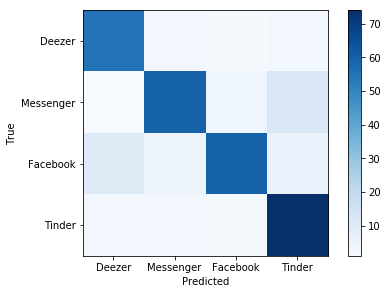

In [47]:
print_confusion_matrix()

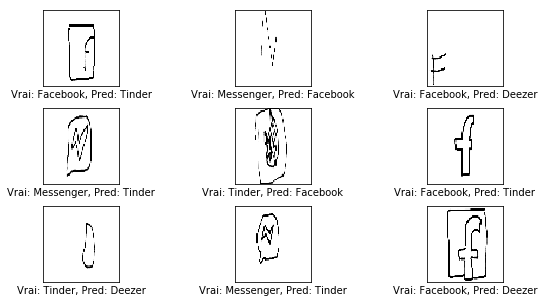

In [48]:
plot_example_errors()

In [49]:
import math

In [50]:
def plot_conv_weights(weights, input_channel=0):

    w = session.run(weights)
    w_min = np.min(w)
    w_max = np.max(w)
    num_filters = w.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):

        if i<num_filters:

            img = w[:, :, input_channel, i]

            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [51]:
def plot_conv_layer(layer, image):

    feed_dict = {x: [image]}
    values = session.run(layer, feed_dict=feed_dict)
    num_filters = values.shape[3]
    num_grids = math.ceil(math.sqrt(num_filters))
    fig, axes = plt.subplots(num_grids, num_grids)


    for i, ax in enumerate(axes.flat):

        if i<num_filters:

            img = values[0, :, :, i]


            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [52]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

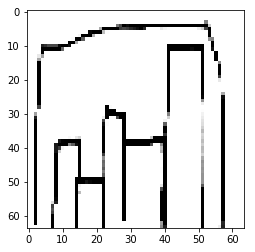

In [74]:
image1 = Test_Classique['data'][24]
plot_image(image1)

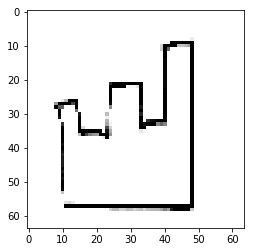

In [76]:
image2 = Test_Classique['data'][19]
plot_image(image2)

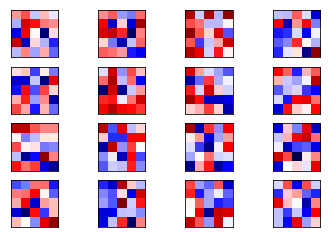

In [55]:
plot_conv_weights(weights=weights_conv1)

In [57]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 32, 32, 16) dtype=float32>

In [58]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 16, 16, 36) dtype=float32>

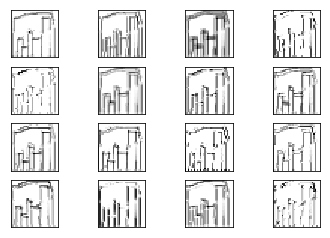

In [77]:
plot_conv_layer(layer=layer_conv1, image=image1)

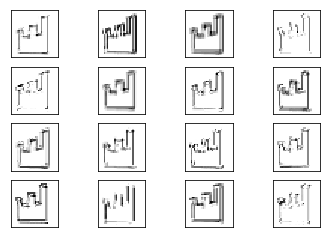

In [78]:
plot_conv_layer(layer=layer_conv1, image=image2)

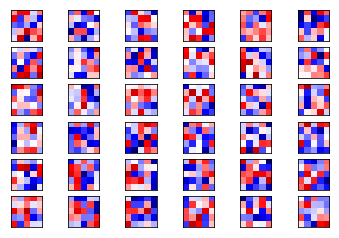

In [60]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

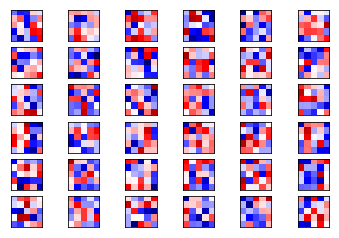

In [61]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

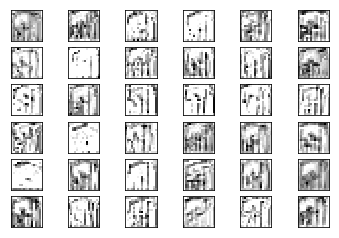

In [79]:
plot_conv_layer(layer=layer_conv2, image=image1)    

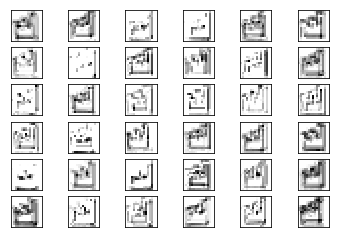

In [80]:
plot_conv_layer(layer=layer_conv2, image=image2)